# nPlan Takehome - Space Insights

### Import Reqs

In [130]:
# data & dfs
import pandas as pd
import numpy as np
import datetime
import math

# viz
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# may need to run below to get latest plotly
# !pip install plotly --upgrade

# feature importance
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier

## Data Review & Clean

In [131]:
# load data & review
astro_fname = 'astronauts.csv'
mission_fname = 'missions.csv'

astro_df = pd.read_csv(astro_fname)
mission_df = pd.read_csv(mission_fname)

print(f'''Astronaut dims: {astro_df.shape}
Astronaut col names: \n {astro_df.columns}''')

print(f'''Mission dims: {mission_df.shape}
Mission col names: \n {mission_df.columns}''')

Astronaut dims: (1277, 25)
Astronaut col names: 
 Index(['Unnamed: 0', 'id', 'number', 'nationwide_number', 'name',
       'original_name', 'sex', 'year_of_birth', 'nationality',
       'military_civilian', 'selection', 'year_of_selection', 'mission_number',
       'total_number_of_missions', 'occupation', 'year_of_mission',
       'mission_title', 'ascend_shuttle', 'in_orbit', 'descend_shuttle',
       'hours_mission', 'total_hrs_sum', 'field21', 'eva_hrs_mission',
       'total_eva_hrs'],
      dtype='object')
Mission dims: (4324, 9)
Mission col names: 
 Index(['Unnamed: 0', 'ID', 'Company Name', 'Location', 'Date', 'Detail',
       'Status Rocket', ' Cost', 'Status Mission'],
      dtype='object')


In [132]:
# Housekeeping
astro_df = astro_df.set_index('id')
astro_df = astro_df.rename(columns={"field21": "eva"})
astro_df = astro_df.drop(columns=['Unnamed: 0'])

mission_df = mission_df.drop(columns=['Unnamed: 0'])
mission_df = mission_df.rename(columns={" Cost": "cost"})
mission_df['cost'] = mission_df['cost'].str.replace(' ', '')
mission_df['cost'] = mission_df['cost'].str.replace(',', '')
mission_df['cost'] = mission_df['cost'].astype(float)
mission_df.Date = pd.to_datetime(mission_df.Date)
mission_df['year'] = mission_df.Date.apply(lambda datetime: datetime.year)
mission_df = mission_df.set_index('ID')

In [133]:
astro_df.head()

,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,eva,eva_hrs_mission,total_eva_hrs
id,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,"Gagarin, Yuri",ГАГАРИН Юрий Алексеевич,male,1934,U.S.S.R/Russia,military,TsPK-1,1960,1,1,pilot,1961,Vostok 1,Vostok 1,Vostok 2,Vostok 3,1.77,1.77,0,0.0,0.0
2,2,2,"Titov, Gherman",ТИТОВ Герман Степанович,male,1935,U.S.S.R/Russia,military,TsPK-1,1960,1,1,pilot,1961,Vostok 2,Vostok 2,Vostok 2,Vostok 2,25.00,25.30,0,0.0,0.0
3,3,1,"Glenn, John H., Jr.","Glenn, John H., Jr.",male,1921,U.S.,military,NASA Astronaut Group 1,1959,1,2,pilot,1962,MA-6,MA-6,MA-6,MA-6,5.00,218.00,0,0.0,0.0
4,3,1,"Glenn, John H., Jr.","Glenn, John H., Jr.",male,1921,U.S.,military,NASA Astronaut Group 2,1959,2,2,PSP,1998,STS-95,STS-95,STS-95,STS-95,213.00,218.00,0,0.0,0.0
5,4,2,"Carpenter, M. Scott","Carpenter, M. Scott",male,1925,U.S.,military,NASA- 1,1959,1,1,Pilot,1962,Mercury-Atlas 7,Mercury-Atlas 7,Mercury-Atlas 7,Mercury-Atlas 7,5.00,5.00,0,0.0,0.0


In [134]:
# Explore Data Frames
astro_df.isnull().sum()

number                      0
nationwide_number           0
name                        0
original_name               5
sex                         0
year_of_birth               0
nationality                 0
military_civilian           0
selection                   5
year_of_selection           0
mission_number              0
total_number_of_missions    0
occupation                  0
year_of_mission             0
mission_title               1
ascend_shuttle              1
in_orbit                    0
descend_shuttle             1
hours_mission               0
total_hrs_sum               0
eva                         0
eva_hrs_mission             0
total_eva_hrs               0
dtype: int64

In [135]:
astro_df = astro_df.drop(columns=['original_name']) # drop original_name - nulls and duplicate to name

In [136]:
astro_df.describe(include='all')

,number,nationwide_number,name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,eva,eva_hrs_mission,total_eva_hrs
count,1277.000000,1277.000000,1277,1277,1277.000000,1277,1277,1272,1277.00000,1277.000000,1277.000000,1277,1277.000000,1276,1276,1277,1276,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000
unique,NaN,NaN,564,2,NaN,40,2,228,NaN,NaN,NaN,12,NaN,361,436,289,432,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,"Ross, Jerry L.",male,NaN,U.S.,military,NASA- 16,NaN,NaN,NaN,MSP,NaN,Salyut 7,STS-42,ISS,STS-42,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,7,1134,NaN,854,769,51,NaN,NaN,NaN,498,NaN,24,8,174,8,NaN,NaN,NaN,NaN,NaN
mean,274.233359,128.754111,NaN,NaN,1951.683634,NaN,NaN,NaN,1985.58888,1.992169,2.982772,NaN,1994.597494,NaN,NaN,NaN,NaN,1050.883984,2968.341410,0.628818,3.661287,10.761410
std,148.185389,97.263590,NaN,NaN,11.435117,NaN,NaN,NaN,12.21917,1.145361,1.400745,NaN,12.583237,NaN,NaN,NaN,NaN,1714.791959,4214.715104,1.165753,7.287245,16.045247
min,1.000000,1.000000,NaN,NaN,1921.000000,NaN,NaN,NaN,1959.00000,1.000000,1.000000,NaN,1961.000000,NaN,NaN,NaN,NaN,0.000000,0.610000,0.000000,0.000000,0.000000
25%,153.000000,47.000000,NaN,NaN,1944.000000,NaN,NaN,NaN,1978.00000,1.000000,2.000000,NaN,1986.000000,NaN,NaN,NaN,NaN,190.030000,482.000000,0.000000,0.000000,0.000000
50%,278.000000,110.000000,NaN,NaN,1952.000000,NaN,NaN,NaN,1987.00000,2.000000,3.000000,NaN,1995.000000,NaN,NaN,NaN,NaN,261.000000,932.000000,0.000000,0.000000,0.000000
75%,390.000000,204.000000,NaN,NaN,1959.000000,NaN,NaN,NaN,1995.00000,3.000000,4.000000,NaN,2003.000000,NaN,NaN,NaN,NaN,382.000000,4264.000000,1.000000,4.720000,19.520000


In [197]:
# get number of nationalities
us_astro_df = astro_df[astro_df['nationality']=='U.S.'].sum()
russian_astro_df =  astro_df[astro_df['nationality']=='U.S.S.R/Russia'].sum()
restofworld_astro_df = astro_df[astro_df['nationality']!='U.S.S.R/Russia']
restofworld_astro_df = restofworld_astro_df[restofworld_astro_df['nationality']!='U.S.']

us_astro_hrs = us_astro_df[['hours_mission']].sum()
russian_astro_hrs = russian_astro_df[['hours_mission']].sum()
restofworld_astro_hrs = restofworld_astro_df[['hours_mission']].sum()

print(f'Comined US nationality astronaut mission time:{us_astro_hrs}')
print(f'Comined US nationality astronaut mission time:{russian_astro_hrs}')
print(f'Comined US nationality astronaut mission time:{restofworld_astro_hrs}')

Comined US nationality astronaut mission time:505768.35
Comined US nationality astronaut mission time:686036.088
Comined US nationality astronaut mission time:hours_mission    150174.41
dtype: float64


In [137]:
mission_df.head()

,Company Name,Location,Date,Detail,Status Rocket,cost,Status Mission,year
ID,,,,,,,,
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,2020
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,2020
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,2020
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,2020


In [138]:
# export list of companies / agencies
agencies = mission_df['Company Name'].unique()
agencies_df = pd.DataFrame(agencies, columns=['name'])
agencies_df.to_csv('agencies.csv')

In [139]:
# read in agency data
agencies_df = pd.read_csv('agencies_status.csv')
mission_df = mission_df.merge(agencies_df, how='left', left_on="Company Name", right_on="name")
mission_df = mission_df.drop(columns=['name'])

# mission location -> launch country
launch_country  = mission_df.Location.str.split(',').str[-1]
launch_country_uniques = launch_country.unique()
launch_country_uniques

array([' USA', ' China', ' Kazakhstan', ' Japan', ' Israel',
       ' New Zealand', ' Russia', ' Shahrud Missile Test Site', ' France',
       ' Iran', ' India', ' New Mexico', ' Yellow Sea', ' North Korea',
       ' Pacific Missile Range Facility', ' Pacific Ocean',
       ' South Korea', ' Barents Sea', ' Brazil', ' Gran Canaria',
       ' Kenya', ' Australia'], dtype=object)

In [140]:
# locations not coutnry -> country
launch_location_patch = {'Shahrud Missile Test Site':'Iran',
                         'New Mexico':'USA',
                         'Yellow Sea':'China',
                         'Pacific Missile Range Facility':'USA',
                         'Pacific Ocean':'Kiribati',
                         'Barents Sea': 'Russia',
                         'Gran Canaria': 'Spain'}

In [141]:
# write countries into df
mission_df['launch_country'] = mission_df.Location.str.split(',').str[-1].str.strip()
launch_loc_patch_keys = launch_location_patch.keys()
# loop through corrections
for i in mission_df.index:
   launch_location = mission_df.loc[i, 'launch_country'] 
   if launch_location in launch_loc_patch_keys:
     mission_df.loc[i, 'launch_country'] = launch_location_patch[launch_location]

In [142]:
mission_df.isnull().sum()

Company Name           0
Location               0
Date                   0
Detail                 0
Status Rocket          0
cost                3360
Status Mission         0
year                   0
state_or_private       0
Country                0
launch_country         0
dtype: int64

In [143]:
mission_df.describe(include='all')

,Company Name,Location,Date,Detail,Status Rocket,cost,Status Mission,year,state_or_private,Country,launch_country
count,4324,4324,4324,4324,4324,964.000000,4324,4324.000000,4324,4324,4324
unique,56,137,4319,4278,2,NaN,4,NaN,2,16,17
top,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",1990-02-07 01:33:00+00:00,Cosmos-3MRB (65MRB) | BOR-5 Shuttle,StatusRetired,NaN,Success,NaN,State,Russia,Russia
freq,1777,235,2,6,3534,NaN,3879,NaN,2884,2066,1398
mean,NaN,NaN,NaN,NaN,NaN,153.792199,NaN,1987.386679,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,288.450732,NaN,18.072562,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,5.300000,NaN,1957.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,1972.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,62.000000,NaN,1984.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,164.000000,NaN,2002.000000,NaN,NaN,NaN


In [144]:
# split mission detail
mission_details = mission_df['Detail'].str.split("|", n = 1, expand = True) 
mission_details = mission_details.rename(columns={0: "launch_sys", 1: "craft_name"})
mission_details.launch_sys = mission_details.launch_sys.str.strip()
mission_details.craft_name = mission_details.craft_name.str.strip()

# no astro side craft have ()s, strip from mission df
mission_details.craft_name = mission_details.craft_name.str.split("(").str[0].str.strip()

mission_df = pd.concat([mission_df, mission_details], axis = 1)
mission_df



,Company Name,Location,Date,Detail,Status Rocket,cost,Status Mission,year,state_or_private,Country,launch_country,launch_sys,craft_name
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00+00:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,2020,Private,USA,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00+00:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,2020,State,China,China,Long March 2D,Gaofen-9 04 & Q-SAT
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00+00:00,Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,2020,Private,USA,USA,Starship Prototype,150 Meter Hop
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00+00:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,2020,State,Russia,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00+00:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,2020,Private,USA,USA,Atlas V 541,Perseverance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00+00:00,Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure,1958,State,USA,USA,Vanguard,Vanguard TV3BU
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00+00:00,Juno I | Explorer 1,StatusRetired,NaN,Success,1958,State,USA,USA,Juno I,Explorer 1
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00+00:00,Vanguard | Vanguard TV3,StatusRetired,NaN,Failure,1957,State,USA,USA,Vanguard,Vanguard TV3
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00+00:00,Sputnik 8K71PS | Sputnik-2,StatusRetired,NaN,Success,1957,State,Russia,Kazakhstan,Sputnik 8K71PS,Sputnik-2


## Merge DataFrames

In [145]:
# left merge to check for lack of matches in astro set
astro_check_df = astro_df.merge(mission_df, how='left', left_on="ascend_shuttle", right_on="craft_name")

astro_check_df.isnull().sum()

number                        0
nationwide_number             0
name                          0
sex                           0
year_of_birth                 0
nationality                   0
military_civilian             0
selection                     5
year_of_selection             0
mission_number                0
total_number_of_missions      0
occupation                    0
year_of_mission               0
mission_title                 1
ascend_shuttle                1
in_orbit                      0
descend_shuttle               1
hours_mission                 0
total_hrs_sum                 0
eva                           0
eva_hrs_mission               0
total_eva_hrs                 0
Company Name                394
Location                    394
Date                        394
Detail                      394
Status Rocket               394
cost                        520
Status Mission              394
year                        394
state_or_private            394
Country 

In [146]:
# Astronauts w/ no match to csv for review
to_check = astro_check_df[astro_check_df['Company Name'].isnull()].ascend_shuttle
to_check = to_check.drop_duplicates()
to_check.to_csv('unmatched_craft.csv')

In [147]:
# incorrect rocket names & corrections
correction_dict = {'MA-6':'Friendship 7',
'Mercury-Atlas 7':'Aurora 7',
'Mercury-Atlas 8':'Sigma 7',
'Gemini 6A':'Gemini VI-A',
'Mercury-Atlas 9':'Faith 7',
'Gemini 5':'Gemini V',
'Gemini 10':'Gemini X',
'Gemini 4':'Gemini IV',
'Gemini 11':'Gemini XI',
'Gemini 7':'Gemini VII',
'Gemini 12':'Gemini XII',
'Gemini 9A':'Gemini IX-A',
'Gemini 8':'Gemini VIII',
'apollo 9':'Apollo 9',
'STS-151-C':'STS-51-C',
'STSÂ­ 91':'STS-91',
'STS-51F':'STS-51-F',
'STS-33':'STS-33R',
'STSÂ­63':'STS-63',
'STSÂ­86':'STS-86',
'STS-26':'STS-26R',
'STS-51B':'STS-51-B',
'STS-30':'STS-30R',
'STS-51A':'STS-51-A',
'STS-28':'STS-28R',
'STS-27':'STS-27R',
'STS-41 B':'STS-41-B',
'STS-51 J':'STS-51-J',
'STS-41 C':'STS-41-C',
'STS-51I':'STS-51-L',
'STS-41C':'STS-41-C',
'STS-61C':'STS-61-C',
'STS-29':'STS-29R',
'STS-41D':'STS-41-D',
'STS-51D':'STS-51-D',
'STS-61B':'STS-61-B',
'STS 51-C':'STS-51-C',
'STS 51-L':'STS-51-L',
'STS-51C':'STS-51-C',
'STS-34':'STS-34R',
'STS-51G':'STS-51-G',
'STS-61A':'STS-61-A',
'STS-61B Atlantis':'STS-61-B',
'STS-40 Columbia':'STS-40',
'STS-51L':'STS-51-L',
'Soyuz TMÂ­20':'Soyuz TMA-20M',
'STSÂ­71':'STS-71',
'STSÂ­60':'STS-60',
'STSÂ­88':'STS-88',
'STS 101':'STS-101',
'STS 102':'STS-102',
'STSÂ­106':'STS-106',
'STSÂ­84':'STS-84',
'STSÂ­113':'STS-113',
'STSÂ­108':'STS-108',
'STSÂ­111':'STS-111',
'STS87':'STS-87',
'STSÂ­89':'STS-89',
'STSÂ­96':'STS-96',
'STSÂ­100':'STS-100',
'STSÂ­105':'STS-105',
'STSÂ­112':'STS-112',
}

In [148]:
# plug rocket name corrections in
astro_ind = astro_df.index
correction_dict_keys = correction_dict.keys()

for i in astro_ind:
  if astro_df.loc[i,'ascend_shuttle'] in correction_dict:
    astro_df.loc[i,'ascend_shuttle'] = correction_dict[astro_df.loc[i,'ascend_shuttle']]

In [149]:
# number of unique manned missions in astro_df
unique_ascend = astro_df.ascend_shuttle.unique()
print(f'Astronauts df contains {len(unique_ascend)} unique ascend shuttles')

Astronauts df contains 412 unique ascend shuttles


In [181]:
# agg astros df to mission level

def map_identity(sex):
    if sex.lower() == 'male':
        return 1
    elif sex.lower() == 'female':
        return 0

def map_m_c(military_civilian):
    if military_civilian.lower() == 'military':
        return 1
    elif military_civilian.lower() == 'civilian':
        return 0


astro_df["age"] = astro_df["year_of_mission"] - astro_df["year_of_birth"]
astro_df["perc_male"] = astro_df["sex"].map(map_identity)
astro_df["perc_military"] = astro_df["military_civilian"].map(map_m_c)

print(astro_df.head())
agg_astro_df = pd.pivot_table(astro_df, index=["year_of_mission", "ascend_shuttle"], aggfunc={
    "name":pd.Series.nunique,
    "nationality":pd.Series.nunique,
    "perc_male":np.mean,
    "perc_military": np.mean,
    "hours_mission": np.mean,
    "age": np.mean,
    "eva": np.mean,
    "mission_number": np.mean}) #creates a pivot table.

agg_astro_df['manned'] = 1
agg_astro_df

    number  nationwide_number  ... perc_male perc_military
id                             ...                        
1        1                  1  ...         1             1
2        2                  2  ...         1             1
3        3                  1  ...         1             1
4        3                  1  ...         1             1
5        4                  2  ...         1             1

[5 rows x 25 columns]


age       eva  ...  perc_military  manned
year_of_mission ascend_shuttle                       ...                       
1961            Vostok 1        27.000000  0.000000  ...       1.000000       1
                Vostok 2        26.000000  0.000000  ...       1.000000       1
1962            Aurora 7        37.000000  0.000000  ...       1.000000       1
                Friendship 7    41.000000  0.000000  ...       1.000000       1
                Sigma 7         39.000000  0.000000  ...       1.000000       1
...                                   ...       ...  ...            ...     ...
2018            Soyuz MS-11     47.000000  1.666667  ...       0.666667       1
2019            Soyuz MS-10     48.000000  0.000000  ...       1.000000       1
                Soyuz MS-12     44.000000  2.666667  ...       0.666667       1
                Soyuz MS-13     46.333333  3.000000  ...       1.000000       1
                Soyuz MS-15     42.666667  0.333333  ...       0.333333       1

[438 rows x 9 columns]

In [182]:
combined_df = mission_df.merge(agg_astro_df, how='left', left_on="craft_name", right_on="ascend_shuttle")

for i in combined_df.index:
  if combined_df.loc[i, 'manned'] != 1:
    combined_df.loc[i, 'manned'] = 0
    

print(f'Merged data frame of shape: {combined_df.shape}')
print('Fields with null values:')
combined_df.isnull().sum()

Merged data frame of shape: (4338, 22)
Fields with null values:


Company Name           0
Location               0
Date                   0
Detail                 0
Status Rocket          0
cost                3363
Status Mission         0
year                   0
state_or_private       0
Country                0
launch_country         0
launch_sys             0
craft_name             0
age                 4107
eva                 4107
hours_mission       4107
mission_number      4107
name                4107
nationality         4107
perc_male           4107
perc_military       4107
manned                 0
dtype: int64

In [183]:
# Number of craft with records in astronauts but not missions
missing_manned_craft = agg_astro_df.merge(mission_df, how='left', left_on="ascend_shuttle", right_on="craft_name")
missing_manned_craft.isnull().sum()

age                   0
eva                   0
hours_mission         0
mission_number        0
name                  0
nationality           0
perc_male             0
perc_military         0
manned                0
Company Name        207
Location            207
Date                207
Detail              207
Status Rocket       207
cost                282
Status Mission      207
year                207
state_or_private    207
Country             207
launch_country      207
launch_sys          207
craft_name          207
dtype: int64

In [184]:
# manned missions
manned_count = combined_df[combined_df['manned']==1].count()
# unmanned missions
unmanned_count = combined_df[combined_df['manned']==0].count()

## Data Viz

In [156]:
# Missions over time

# cumulative missions
years = mission_df.year.unique()
years.sort() # list of years in order for x axis

# Used for text labels on plot
cumu_missions_xlabs = []
cumu_missions_ylabs = []
cumu_missions_txtlabs = []

missions_pa = []

for year in years:
  tmp = mission_df[mission_df.year == year].shape[0] # loop yrs, take rows in yr
  missions_pa.append(tmp)

fig = go.Figure([go.Scatter(x=years, y=missions_pa,
                 line=dict(color='LightSeaGreen', width=4))]
                )

# era annotations
fig.add_vrect(
    x0="1957", x1="1975",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(1966)
cumu_missions_ylabs.append(10)
cumu_missions_txtlabs.append("Space Race")

fig.add_vrect(
    x0="1975", x1="2000",
    fillcolor="lightgrey", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(1988)
cumu_missions_ylabs.append(10)
cumu_missions_txtlabs.append("Multinational Cooperation")

fig.add_vrect(
    x0="2000", x1="2020",
    fillcolor="khaki", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(2010)
cumu_missions_ylabs.append(10)
cumu_missions_txtlabs.append("Private Space Race")

# Event annotations
# First manned flight
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=1961, y0=52, x1=1961, y1=100,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(1961)
cumu_missions_ylabs.append(105)
cumu_missions_txtlabs.append("First Person In Space")

# Moon landing
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=1969, y0=103, x1=1969, y1=75,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(1969)
cumu_missions_ylabs.append(70)
cumu_missions_txtlabs.append("Moon Landing")

#ESA founded
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=1975, y0=113, x1=1975, y1=75,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(1975)
cumu_missions_ylabs.append(70)
cumu_missions_txtlabs.append("ESA Founded")

#End of cold war
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=1991, y0=59, x1=1991, y1=100,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(1991)
cumu_missions_ylabs.append(105)
cumu_missions_txtlabs.append("Cold War Ends")

#ISS launched
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=1998, y0=68, x1=1998, y1=110,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(1998)
cumu_missions_ylabs.append(115)
cumu_missions_txtlabs.append("ISS Launched")

#Reusable rocket
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=2015, y0=52, x1=2015, y1=40,
    line=dict(
        color="black",
        width=3,
    ))

cumu_missions_xlabs.append(2015)
cumu_missions_ylabs.append(35)
cumu_missions_txtlabs.append("First Reusable Rocket")

# Create scatter trace of text labels
fig.add_trace(go.Scatter(
    x=cumu_missions_xlabs,
    y=cumu_missions_ylabs,
    text=cumu_missions_txtlabs,
    mode="text",
))

fig.update_layout(title_text="Launches By Year", 
                  xaxis_title="Year",
                  yaxis_title="Number of Launches",
                  font_color="black",
                  font_size=16,
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25},
                  )
fig.show()

In [52]:
# annual missions by state/private
missions_pa_private = []
missions_pa_state = []
for year in years:
  # create df filtered to yr & private/state. Take row count and append to list 
  yr_tmp = mission_df[mission_df.year == year]
  state_count = yr_tmp[yr_tmp.state_or_private=='State'].shape[0]
  private_count = yr_tmp[yr_tmp.state_or_private=='Private'].shape[0]
  missions_pa_state.append(state_count)
  missions_pa_private.append(private_count)

# plot as bar
fig = go.Figure(data=[
    go.Bar(name='State', x=years, y=missions_pa_state, marker_color='royalblue'),
    go.Bar(name='Private', x=years, y=missions_pa_private, marker_color='firebrick')
])

# Change the bar mode -> stacked
fig.update_layout(barmode='stack')
fig.update_layout(title_text="Private & State Launches By Year", 
                  xaxis_title="Year",
                  yaxis_title="Number of Launches",font_size=16,
                  font_color="black",
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25})
fig.show()

In [157]:
# num entities active in a given year
active_nations = []
for year in years:
  # filter df for year then count countries in that year/df
  yr_tmp = mission_df[mission_df.year == year]
  countries = yr_tmp['Country'].unique()
  active_nations.append(len(countries))

fig = go.Figure([go.Scatter(x=years, y=active_nations,
                           line=dict(color='LightSeaGreen', width=4))])

# Include era annotations
cumu_missions_xlabs = []
cumu_missions_ylabs = []
cumu_missions_txtlabs = []

fig.add_vrect(
    x0="1957", x1="1975",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(1966)
cumu_missions_ylabs.append(8)
cumu_missions_txtlabs.append("Space Race")

fig.add_vrect(
    x0="1975", x1="2000",
    fillcolor="lightgrey", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(1988)
cumu_missions_ylabs.append(3)
cumu_missions_txtlabs.append("Multinational Cooperation")

fig.add_vrect(
    x0="2000", x1="2020",
    fillcolor="khaki", opacity=0.5,
    layer="below", line_width=0)

cumu_missions_xlabs.append(2010)
cumu_missions_ylabs.append(3)
cumu_missions_txtlabs.append("Private Space Race")

# Create scatter trace of text labels
fig.add_trace(go.Scatter(
    x=cumu_missions_xlabs,
    y=cumu_missions_ylabs,
    text=cumu_missions_txtlabs,
    mode="text",
))


fig.update_layout(title_text="Nations Active By Year", 
                  xaxis_title="Year",
                  yaxis_title="# Nations Active",font_size=16,
                  font_color="black",
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25})
fig.show()


In [158]:
# num entities active in a given year
active_entities = []
for year in years:
  # as above - filter on yr, then count unique entities
  yr_tmp = mission_df[mission_df.year == year]
  countries = yr_tmp['Company Name'].unique()
  active_entities.append(len(countries))

fig = go.Figure([go.Scatter(x=years, y=active_entities,
                            line=dict(color='LightSeaGreen', width=4))])
fig.update_layout(title_text="Entities Active By Year", 
                  xaxis_title="Year",
                  yaxis_title="# Entities Active",font_size=16,
                  font_color="black",
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25})
fig.show()

In [159]:
# % failure in a given year
perc_fails = []
for year in years:
  # filter on year then take succes over total row count
  yr_tmp = mission_df[mission_df.year == year]
  annual_success = yr_tmp[yr_tmp['Status Mission']=="Success"].shape[0]
  annual_failure = yr_tmp.shape[0] - annual_success #anything not success -> failure
  perc_fails.append((annual_failure/yr_tmp.shape[0])*100)

fig = go.Figure([go.Scatter(x=years, y=perc_fails,
                            line=dict(color='firebrick', width=4))])
fig.update_layout(title_text="Failure Rate By Year", 
                  xaxis_title="Year",
                  yaxis_title="% Failures",font_size=16,
                  font_color="black",
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25})
fig.show()

In [160]:
# Avg cost of a mission pa
avg_cost = []
for year in years:
  # year df, then avg of cost for those w/ vals
  yr_tmp = mission_df[mission_df.year == year]
  tot_spend = yr_tmp.cost.mean()
  if math.isnan(tot_spend):
    tot_spend = 0
  avg_cost.append(tot_spend)
  
fig = go.Figure([go.Scatter(x=years, y=avg_cost,
                            line=dict(color='royalblue', width=4))])
fig.update_layout(title_text="Avg Launch Cost Over Time", 
                  xaxis_title="Year",
                  yaxis_title="Avg Mission Cost ($M)",font_size=16,
                  font_color="black",
                  title={
                  'y':0.9,
                  'x':0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font_size':25})
fig.show()

In [162]:
def create_sankey_indices(source, target):
  """Create labels and dict to map needed to build sankey from inputs"""
  source_uniques = source.unique()
  target_uniques = target.unique()
  sankey_labs = np.concatenate((source_uniques, target_uniques))
  labels_dict = {}
  count = 0
  for lab in sankey_labs:
    labels_dict[lab] = count
    count += 1
  return sankey_labs, labels_dict

def make_lists(source, target, labels_dict):
  """Create list of indices used to plot sankey. Setup to use count as value"""
  source = source.tolist()
  target = target.tolist()
  source_indices = []
  target_indices = []
  for i, j in zip(source, target):
    ind = labels_dict[i]
    source_indices.append(ind)
    ind = labels_dict[j]
    target_indices.append(ind)
  
  value = len(source_indices)*[1]
  return source_indices, target_indices, value


def plot_sankey(sankey_labels, source_ind, target_ind, value, title):
  """Plot sankey with valid inputs"""
  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "grey", width = 0.5),
        label = sankey_labels,
        color = "blue",
      ),
      link = dict(
        source = source_ind, # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = target_ind,
        value = value,
        color = "green"
    ))
  ])

  fig.update_layout(title_text=title, font_size=25)
  fig.show()


def generate_sankey(source, target, title='Sankey Plot'):
  """end-to-end sankey creation"""
  sankey_labs, labels_dict = create_sankey_indices(source, target)
  source_indices, target_indices, value = make_lists(source, target, labels_dict)
  plot_sankey(sankey_labs, source_indices, target_indices, value, title=title)

In [166]:
generate_sankey(mission_df['Country'], mission_df['Status Mission'], title="Outcomes By Country Of Origin")

In [167]:
generate_sankey(mission_df['launch_country'], mission_df['Status Mission'], title="Outcomes By Launch Country")

In [168]:
generate_sankey(mission_df['state_or_private'], mission_df['Status Mission'], title="State & Private Mission Outcomes")

In [169]:
owner_locations = mission_df['Country'].copy()
launch_locations = mission_df['launch_country'].copy()

# agg countries to give view of us vs ussr vs ROW
def agg_geogs(locations):
  for i in range(len(locations)):
    if locations[i] == 'Kazakhstan':
      locations[i] = 'Russia'
    elif (locations[i] != 'Russia') and (locations[i] != 'USA'):
      locations[i] = 'Rest of World'
  return locations

owner_locations = agg_geogs(owner_locations)
launch_locations = agg_geogs(launch_locations)

In [170]:
generate_sankey(owner_locations, mission_df['Status Mission'], title="Aggregate Source Country Success")

In [171]:
generate_sankey(launch_locations, mission_df['Status Mission'], title="Aggregate Launch Country Success")

In [172]:
# Plot table of values for % success and no missions by origin country
countries = mission_df['Country'].unique()
countries_df = pd.DataFrame({ 'country': countries })
for country in countries_df.index:
  country_name =  countries_df.loc[country,'country']
  tmp = mission_df[mission_df['Country']==country_name] # filter to relevant only
  successes = tmp[tmp['Status Mission'] == 'Success'].shape[0] # row count of success vals
  fails = tmp[tmp['Status Mission'] != 'Success'].shape[0] # row count of fails
  countries_df.loc[country, 'success_perc'] = (successes/(fails+successes)) # overall perc
  countries_df.loc[country, 'missions'] = tmp.shape[0]

countries_df = countries_df.sort_values(by=['success_perc'], ascending=False)
countries_df

,country,success_perc,missions
14,Ukraine,1.000000,4.0
15,Italy,1.000000,9.0
6,France,0.955479,292.0
3,Japan,0.925620,121.0
8,Germany,0.923077,13.0
2,Russia,0.911423,2066.0
1,China,0.907063,269.0
9,Switzerland,0.906977,43.0
0,USA,0.875907,1378.0
7,India,0.828947,76.0


In [173]:
# Plot table of values for % success and no missions by launch country
countries = mission_df['launch_country'].unique()
countries_df = pd.DataFrame({ 'country': countries })
for country in countries_df.index:
  country_name =  countries_df.loc[country,'country']
  tmp = mission_df[mission_df['launch_country']==country_name] # filter to relevant only
  successes = tmp[tmp['Status Mission'] == 'Success'].shape[0] # row count of success vals
  fails = tmp[tmp['Status Mission'] != 'Success'].shape[0] # row count of fails
  countries_df.loc[country, 'success_perc'] = (successes/(fails+successes)) # overall perc
  countries_df.loc[country, 'missions'] = tmp.shape[0]

countries_df = countries_df.sort_values(by=['success_perc'], ascending=False)
countries_df

,country,success_perc,missions
15,Kenya,1.000000,9.0
14,Spain,1.000000,2.0
8,France,0.940594,303.0
6,Russia,0.933476,1398.0
11,Kiribati,0.916667,36.0
1,China,0.907063,269.0
3,Japan,0.896825,126.0
0,USA,0.879170,1349.0
2,Kazakhstan,0.867332,701.0
5,New Zealand,0.846154,13.0


## Feature Importance

In [185]:
# drop unmanned missions
manned_missions = combined_df[combined_df['manned']==1]

# encode success
for i in manned_missions.index:
  if manned_missions.loc[i, 'Status Mission'] == 'Success':
    manned_missions.loc[i,'outcome'] = 1
  else:
    manned_missions.loc[i,'outcome'] = 0

# drop dims typically unique to entry or duplicate of others
manned_missions = manned_missions.drop(columns=['Detail', 'Status Rocket', 'manned', 'Location', 'launch_sys', 'craft_name', 'Status Mission'])
manned_missions = manned_missions.rename(columns={'name':'no_astros'})

manned_missions

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Company Name,Date,cost,year,state_or_private,Country,launch_country,age,eva,hours_mission,mission_number,no_astros,nationality,perc_male,perc_military,outcome
98,Roscosmos,2019-09-25 13:57:00+00:00,NaN,2019,State,Russia,Kazakhstan,42.666667,0.333333,1861.376667,1.666667,3.0,3.0,0.666667,0.333333,1.0
122,Roscosmos,2019-07-20 16:28:00+00:00,NaN,2019,State,Russia,Kazakhstan,46.333333,3.000000,4303.030000,2.000000,3.0,3.0,1.000000,1.000000,1.0
155,Roscosmos,2019-03-14 19:14:00+00:00,NaN,2019,State,Russia,Kazakhstan,44.000000,2.666667,5700.016667,2.000000,3.0,2.0,0.666667,0.666667,1.0
186,Roscosmos,2018-12-03 11:31:00+00:00,NaN,2018,State,Russia,Kazakhstan,47.000000,1.666667,4887.000000,2.000000,3.0,3.0,0.666667,0.666667,1.0
208,Roscosmos,2018-10-11 08:40:00+00:00,NaN,2018,State,Russia,Kazakhstan,43.000000,3.000000,0.000000,1.000000,1.0,1.0,1.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,RVSN USSR,1962-08-11 08:30:00+00:00,NaN,1962,State,Russia,Kazakhstan,33.000000,0.000000,94.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
4171,NASA,1962-05-24 12:45:00+00:00,NaN,1962,State,USA,USA,37.000000,0.000000,5.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
4191,NASA,1962-02-20 14:47:00+00:00,NaN,1962,State,USA,USA,41.000000,0.000000,5.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0
4219,RVSN USSR,1961-08-06 06:00:00+00:00,NaN,1961,State,Russia,Kazakhstan,26.000000,0.000000,25.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0


In [186]:
# Define functions to extract & plot feature importance using different methods

def correlation_plot(df):
    """
    Returns correlation plot from matplotlib using inbuilt pandas corr()
    """
    correlations = df.corr()
    output_df = pd.DataFrame(correlations)
    cols = output_df.columns
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(cols), 1)
    ax.set_yticks(ticks)
    ax.set_yticklabels(cols)
    plt.rcParams['font.size'] = '16'
    plt.title('Feature Correlation Plot')
    plt.show()
    return output_df

def dt_cart_feature_importance_graphs(in_x, in_y, x_columns):
    """
    CART algorithm

    takes imput data and displays two graphics of feature importance. Intended for use for selecting threshold for
    full dt cart method

    """
    x_train = in_x.values
    y_train = in_y.values  # label class

    # fit the model on the training data set
    model = ExtraTreesClassifier()
    model.fit(x_train, y_train)
    importance_var = model.feature_importances_

    feature_importance = pd.DataFrame({"features": x_columns,
                                       "importance": importance_var})

    feature_importance_sorted = feature_importance.sort_values("importance", ascending=False)

    #sorted
    plt.figure(figsize=(12,6))
    plt.xticks(rotation=90)
    plt.bar(feature_importance_sorted["features"], feature_importance_sorted["importance"])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Sorted Extra Trees Feature Importance')
    plt.show()

def select_k_best_graph(in_x, in_y, quant):
    """
    Select K Best Algorithm

    applies select_k_best scikit learn method and plots sorted feature importance
    set quant either to number of columns, or to desired threshold number

    """
    X = in_x.values
    Y = in_y.values
    plot_data = SelectKBest(score_func=f_classif, k=quant)
    fit = plot_data.fit(X, Y)
    indices = np.argsort(fit.scores_)[::-1]
    features = []
    for i in range(quant):
        features.append(in_x.columns[indices[i]])
    plt.figure(figsize=(12,6))
    plt.xticks(rotation=90)
    plt.bar(features, fit.scores_[indices[range(quant)]], color='r', align='center')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Select K Best Feature Importance')
    plt.show()

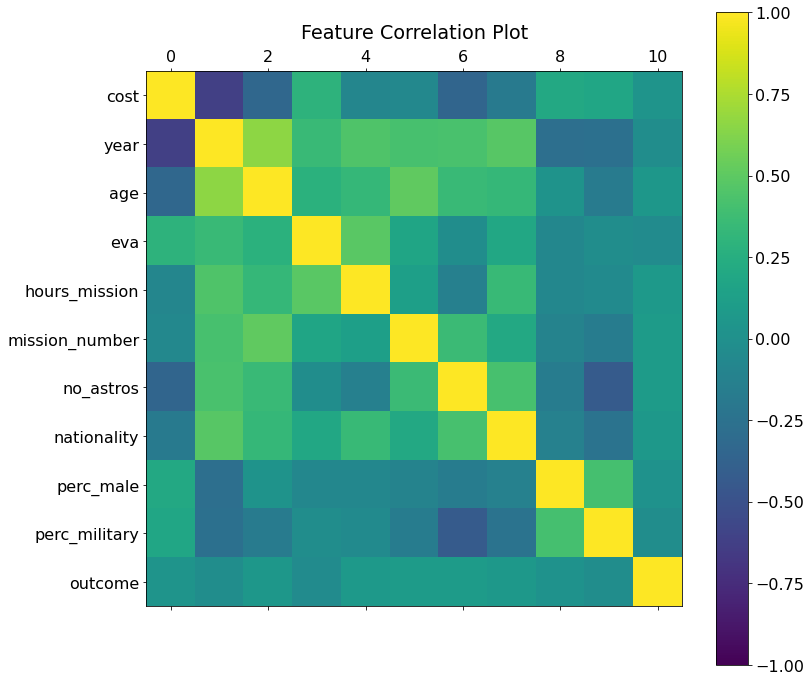

,cost,year,age,eva,hours_mission,mission_number,no_astros,nationality,perc_male,perc_military,outcome
cost,1.000000,-0.623856,-0.334928,0.294474,-0.084860,-0.065237,-0.351241,-0.174578,0.208145,0.184375,0.036647
year,-0.623856,1.000000,0.657346,0.355101,0.448129,0.421824,0.427390,0.476632,-0.272226,-0.261285,-0.018828
age,-0.334928,0.657346,1.000000,0.276740,0.331243,0.514699,0.354601,0.328626,0.024464,-0.166626,0.059122
eva,0.294474,0.355101,0.276740,1.000000,0.491929,0.178726,-0.015833,0.201204,-0.075198,-0.022775,-0.035886
hours_mission,-0.084860,0.448129,0.331243,0.491929,1.000000,0.128797,-0.126950,0.345430,-0.073601,-0.044129,0.072456
mission_number,-0.065237,0.421824,0.514699,0.178726,0.128797,1.000000,0.365627,0.208832,-0.102045,-0.162504,0.101321
no_astros,-0.351241,0.427390,0.354601,-0.015833,-0.126950,0.365627,1.000000,0.418071,-0.157912,-0.422256,0.100190
nationality,-0.174578,0.476632,0.328626,0.201204,0.345430,0.208832,0.418071,1.000000,-0.117229,-0.236961,0.064904
perc_male,0.208145,-0.272226,0.024464,-0.075198,-0.073601,-0.102045,-0.157912,-0.117229,1.000000,0.406251,0.020748
perc_military,0.184375,-0.261285,-0.166626,-0.022775,-0.044129,-0.162504,-0.422256,-0.236961,0.406251,1.000000,-0.022309


In [187]:
correlation_plot(manned_missions)

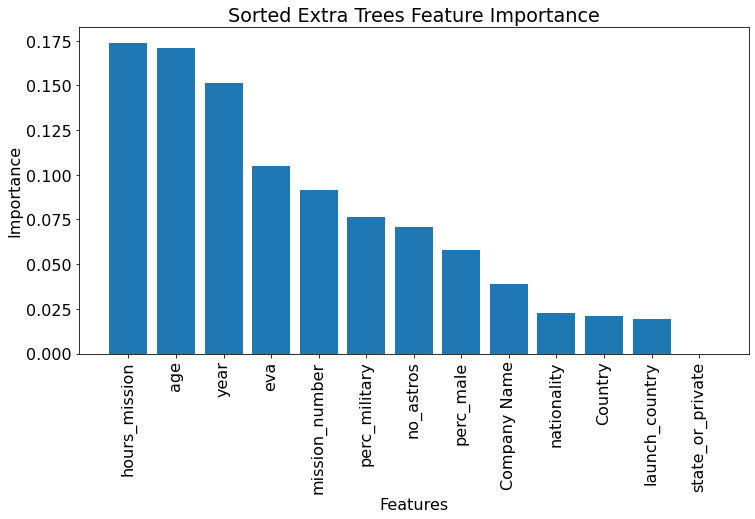

In [188]:
# encode and drop vals
x_cols_to_drop = ['outcome', 'Date', 'cost'] # duplicate or mostly empty
x_cols_to_encode = ['state_or_private', 'Country', 'launch_country', 'Company Name'] # categorical -> num

# sklearn encoder
ord_enc = OrdinalEncoder()

for target_col in x_cols_to_encode:
  manned_missions[target_col] = ord_enc.fit_transform(manned_missions[[target_col]])

y = manned_missions['outcome']
x = manned_missions.drop(columns=x_cols_to_drop)
x_cols = x.columns

dt_cart_feature_importance_graphs(x, y, x_cols)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning:

Features [2] are constant.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning:

invalid value encountered in true_divide



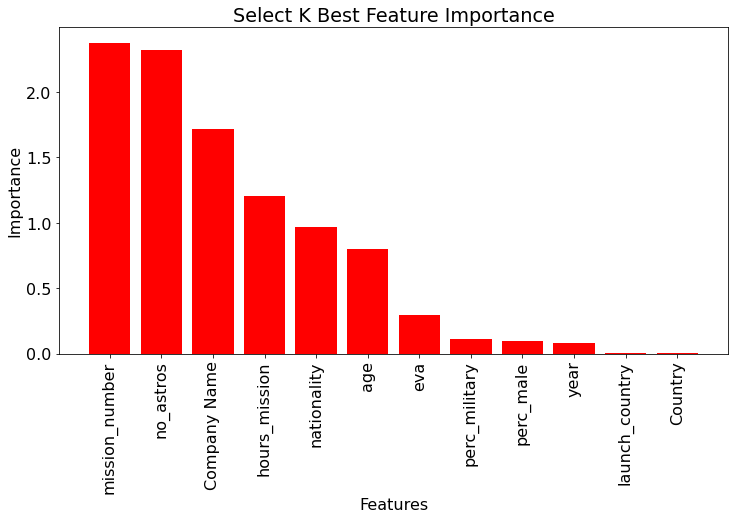

In [189]:
select_k_best_graph(x, y, len(x_cols))